In [1]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn
import sklearn.metrics as metrics

## 通过words similarity来计算离散情绪词和时间流逝感的关系（weibo bagging）

In [121]:
## word similarity (word2vec)(离散情绪与sentence word的bagging的similarity)

In [134]:
from tqdm.notebook import tqdm

In [137]:
from harvesttext import HarvestText
from harvesttext.resources import get_qh_typed_words
import re

ht = HarvestText()
typed_words = get_qh_typed_words()
ht.add_typed_words(typed_words)
ht.add_new_words(['时光飞逝', '时间飞逝', '白驹过隙', '一眨眼', '光阴似箭', '岁月如梭', '时光匆匆', '时间匆匆', '如梭', '转眼', '日月如梭', '转瞬即逝', '一下子', '一晃', '如驹', '过隙', '即逝', '一转眼', '时光荏苒', '一晃而过', '忽忽', '光阴似箭', '光阴如箭', '光阴', '度日如年', '漫长', '漫漫', '漫漫长夜', '这么久', '三秋', '日长似岁', '漫长', '度日如年', '一日三秋', '寸阴若岁', '时间过得慢', '过得慢'])
#ht.add_entities(['时间'])
puncs = re.compile(r"\s|\.|\(|\)|"+"|".join([":",",","，","。","、","：","；","？","！","（","）","《","》","#",
                         "-","——","·","……","‘","’","“","”","/",r"\\","\\[","\\]","【","】","\\|","℃","—>","\n"]))

In [145]:
stop_words = []
with open("stopwords/cn_stopwords.txt") as F:
    for line in F:
        stop_words.append(line.strip())
stop_words = set(stop_words)

In [127]:
# load word2vec, the model can be downloaded from https://cloud.tsinghua.edu.cn/f/6a38cc42c881499798ae/?dl=1 
from gensim.models import KeyedVectors
model_dir = "../../Dict_construct/Words/src/"
model = KeyedVectors.load_word2vec_format(os.path.join(model_dir,"word2vec128.model"), binary=False)

In [181]:
# 去除停用词：https://github.com/goto456/stopwords
def split_weibo(weibo, do=0):
    all_words = []
    sentences = ht.cut_sentences(weibo)
    for sen in sentences:
        sen_split = []
        for param in puncs.split(sen):
            if len(param):
                sen_split+=ht.seg(param,stopwords=["全文"],return_sent=False)
        if len(sen_split):
            if do:
                print(sen_split)
            all_words += sen_split
    select_words = []
    vectors = []
    for w in all_words:
        if w not in stop_words:
            select_words.append(w)
            try:
                v = model.get_vector(w)
                vectors.append(v/np.linalg.norm(v))
            except:
                continue
    return select_words,np.array(vectors)

In [122]:
# load 情绪词典data
mood_dir = "./Lexicon_weibo_mood_dictionary/"
mood_dict = {}
for file in os.listdir(mood_dir):
    if file[:3] != "总词库":
        mood = file[:2]
        mood_dict[mood] = []
        with open(os.path.join(mood_dir,file)) as F:
            for line in F:
                mood_dict[mood].append(line.strip())

In [322]:
m_num = {}
for m in mood_dict:
    print(m,len(mood_dict[m]))
    m_num[m] = len(mood_dict[m])

期望 358
悲伤 461
快乐 428
厌恶 379
焦虑 382
惊讶 131
喜爱 621
愤怒 396


In [182]:
mood_vector = {}
cnt = {}
all_cnt = {}
for mood in mood_dict.keys():
    cnt[mood] = 0
    all_cnt[mood] = 0
    vectors = []
    for word in mood_dict[mood]:
        try:
            v = model.get_vector(word)
            cnt[mood] += 1
            vectors.append(v/np.linalg.norm(v))
        except:
            print("Model not include %s"%(word))
        all_cnt[mood] += 1
    mood_vector[mood] = np.array(vectors)
for mood in cnt.keys():
    print("Mood %s: %d/%d(%.2f%%)"%(mood,cnt[mood],all_cnt[mood],cnt[mood]/all_cnt[mood]*100))

Model not include 愿我们
Model not include 健健康康
Model not include 愿所有人
Model not include 一定要
Model not include 越来越好
Model not include 好起来
Model not include 走下去
Model not include 更好的
Model not include 要努力
Model not include 想成为
Model not include 新的一年
Model not include 祝大家
Model not include 冲呀
Model not include 要幸福
Model not include 早日康复
Model not include 不要放弃
Model not include 元旦快乐
Model not include 超越妹妹
Model not include 争气点
Model not include 努力实现
Model not include 立个flag
Model not include 下星期
Model not include 打起精神
Model not include 一定得
Model not include 都要
Model not include 再也不
Model not include 想吃
Model not include 想买
Model not include 想去
Model not include 许一个愿
Model not include 
Model not include 温柔以待
Model not include 不舒服
Model not include 想哭
Model not include 想死
Model not include 悲催
Model not include 要死了
Model not include 呼吸困难
Model not include 哭出来
Model not include 不高兴
Model not include 掉眼泪
Model not include 废了
Model not include 心情不好
Model not include 负面情绪
Model not include 负能量
Mode

In [171]:
mood_dict.keys()

dict_keys(['期望', '悲伤', '快乐', '厌恶', '焦虑', '惊讶', '喜爱', '愤怒'])

In [620]:
all_cnt = 0
for k,v in mood_vector.items():
    print(k,len(v))
    all_cnt += len(v)

期望 326
悲伤 434
快乐 395
厌恶 343
焦虑 353
惊讶 119
喜爱 587
愤怒 345


In [622]:
all_cnt

2902

In [193]:
# split words and get similarity
weibo_sim = {} # id:{mood:[w1_sim,w2_sim,...],}
all_ids = All_weibo["id"].tolist()
all_content = All_weibo["content"].tolist()
for idx, content in tqdm(zip(all_ids,all_content)):
    weibo_sim[idx] = {}
    content,vectors = split_weibo(content,do=0)
    for key in mood_vector.keys():
        weibo_sim[idx][key] = np.matmul(vectors,mood_vector[key].T).max(axis=1)

In [640]:
random_weibo = pd.read_csv("../Random_data/random_data.csv")
# split words and get similarity
weibo_sim_rnd = {} # id:{mood:[w1_sim,w2_sim,...],}
random_ids = random_weibo["_id"].tolist()
random_content = random_weibo["content"].tolist()
for idx, content in tqdm(zip(random_ids,random_content)):
    weibo_sim_rnd[idx] = {}
    content,vectors = split_weibo(content,do=0)
    if len(vectors)>0:
        for key in mood_vector.keys():
            weibo_sim_rnd[idx][key] = np.matmul(vectors,mood_vector[key].T).max(axis=1)

In [634]:
idx, content

('Ix5yX2Gto', [])

In [614]:
def draw_multiple(Fast_m,Slow_m,labels=[],xlabels=["Fast","Slow"]):
    plt.figure(figsize=(16,5))
    ax1 = plt.subplot(1,2,1)
    ax1.bar(range(len(labels)),Fast_m)
    ax2 = plt.subplot(1,2,2)
    ax2.bar(range(len(labels)),Slow_m)
    ax1.set_xticks(range(len(labels)))
    ax1.set_xticklabels(labels,fontsize=12)
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels,fontsize=12)
    for i,v in enumerate(Fast_m.tolist()):
        ax1.text(i,v,"%.4f"%(v),ha='center',fontsize=14)
    for i,v in enumerate(Slow_m.tolist()):
        ax2.text(i,v,"%.4f"%(v),ha='center',fontsize=14)
    ax1.set_xlabel(xlabels[0],fontsize=18)
    ax2.set_xlabel(xlabels[1],fontsize=18)
    Min = min(Fast_m.min(),Slow_m.min())
    Max = max(Fast_m.max(),Slow_m.max())
    ax1.set_ylim(Min*0.95,Max*1.05)
    ax2.set_ylim(Min*0.95,Max*1.05)

In [316]:
moods = ['喜爱','快乐','期望','惊讶']+[x for x in sorted(mood_vector.keys()) if x not in ['喜爱','快乐','期望','惊讶']]
moods_eng = ["love","joy",'hope','surprise',"disgust","sad","angry","anxiety"]

In [629]:
weibo_m.max(axis=0).shape

(15,)

Fast    35372
Slow     3527
Name: time, dtype: int64

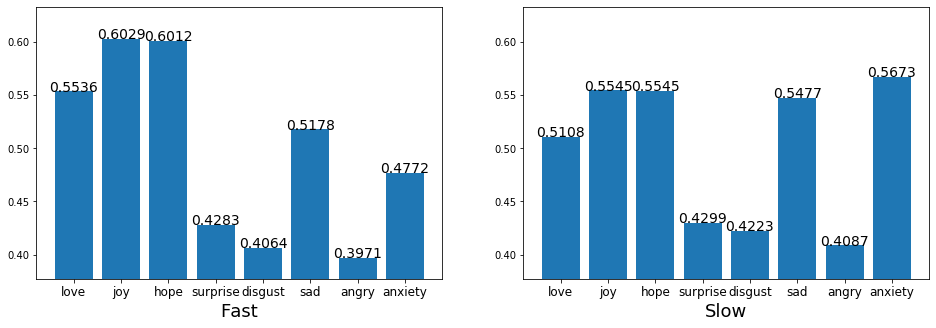

In [536]:
# 取情绪较强的word在每种情绪下的score的均值（最终确定）
threshold = 0.8
weibo_avgsim = {} # id:[]
for idx in weibo_sim:
    weibo_m = np.array([weibo_sim[idx][m] for m in moods])
    if (weibo_m.max(axis=0)>threshold).sum()>0:
        weibo_avgsim[idx] = weibo_m[:,np.where(weibo_m.max(axis=0)>threshold)].reshape(weibo_m.shape[0],-1).mean(axis=1)
#     weibo_avgsim[idx] = [weibo_sim[idx][mood].mean() for mood in moods]
weibo_moods = pd.DataFrame.from_dict(weibo_avgsim,orient='index',columns=moods)
weibo_moods = weibo_moods.reset_index().rename(columns={"index":"id"})
weibo_moods = weibo_moods.merge(All_weibo[["id","content","time"]],on="id",how="left")
display(weibo_moods.time.value_counts())
draw_multiple(weibo_moods.loc[weibo_moods.time=="Fast",moods].mean().values,
              weibo_moods.loc[weibo_moods.time=="Slow",moods].mean().values,moods_eng)

In [643]:
# 取情绪较强的word在每种情绪下的score的均值（最终确定）
threshold = 0.8
weibo_avgsim_rnd = {} # id:[]
for idx in weibo_sim_rnd:
    if len(weibo_sim_rnd[idx]):
        weibo_m_rnd = np.array([weibo_sim_rnd[idx][m] for m in moods])
        if (weibo_m_rnd.max(axis=0)>threshold).sum()>0:
            weibo_avgsim_rnd[idx] = weibo_m_rnd[:,np.where(weibo_m_rnd.max(axis=0)>threshold)].reshape(weibo_m_rnd.shape[0],-1).mean(axis=1)
#     weibo_avgsim_rnd[idx] = [weibo_sim_rnd[idx][mood].mean() for mood in moods]
weibo_m_rndoods = pd.DataFrame.from_dict(weibo_avgsim_rnd,orient='index',columns=moods)
weibo_m_rndoods = weibo_m_rndoods.reset_index().rename(columns={"index":"id"})
# weibo_m_rndoods = weibo_m_rndoods.merge(All_weibo[["id","content","time"]],on="id",how="left")
# display(weibo_m_rndoods.time.value_counts())
# draw_multiple(weibo_m_rndoods.loc[weibo_m_rndoods.time=="Fast",moods].mean().values,
#               weibo_m_rndoods.loc[weibo_m_rndoods.time=="Slow",moods].mean().values,moods_eng)

In [645]:
weibo_m_rndoods.to_csv("pred_results/8mood_sim_rnd.csv",index=False)

In [579]:
weibo_moods.loc[weibo_moods.time=="Slow",moods].mean()

喜爱    0.510834
快乐    0.554516
期望    0.554453
惊讶    0.429868
厌恶    0.422256
悲伤    0.547676
愤怒    0.408685
焦虑    0.567278
dtype: float64

In [580]:
os.makedirs("pred_results",exist_ok=True)
weibo_moods.drop_duplicates(subset=["id"],inplace=True)
weibo_moods.to_csv("./pred_results/8mood_w2v_simscore.csv",index=False)

In [586]:
cnt_mood = pd.read_csv("./matching_detail.csv")

In [591]:
cnt_mood.drop_duplicates(subset=["id"],inplace=True)

In [593]:
cnt_mood.shape,weibo_moods.shape,All_weibo.shape

((44583, 11), (38878, 11), (44577, 31))

In [597]:
cnt_mood = cnt_mood.loc[cnt_mood["id"].isin(All_weibo["id"].tolist())]

In [598]:
cnt_mood.shape,weibo_moods.shape,All_weibo.shape

((44577, 11), (38878, 11), (44577, 31))

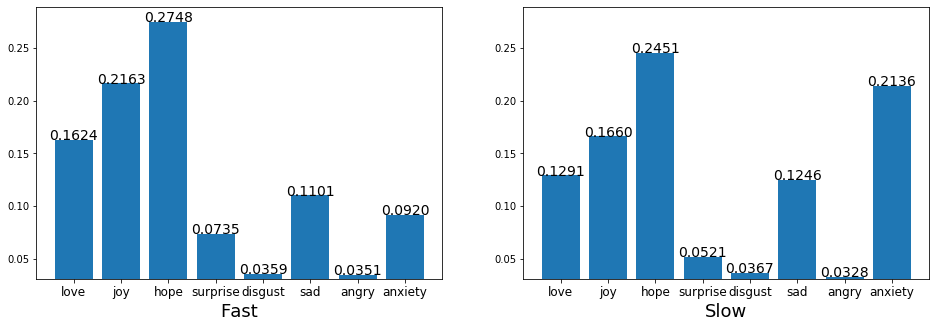

In [605]:
draw_multiple(cnt_mood.loc[cnt_mood.time=="Fast",moods].mean().values,
              cnt_mood.loc[cnt_mood.time=="Slow",moods].mean().values,moods_eng)

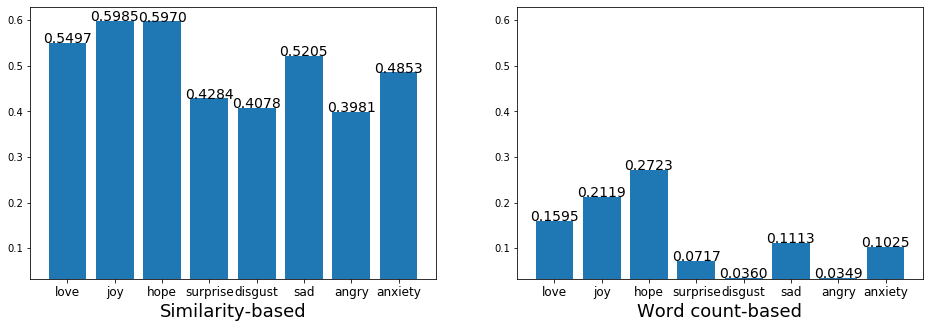

In [617]:
draw_multiple(weibo_moods[moods].mean().values,
             cnt_mood[moods].mean().values,moods_eng,xlabels=["Similarity-based","Word count-based"])

In [602]:
cnt_mood.to_csv("./pred_results/8mood_cnt_normscore.csv",index=False)